In [1]:
import numpy as np
import scipy
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from os import path


In [2]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [3]:
import itertools
from operator import add
from quimb import *
import quimb

r=2 # local Hilbert space dim

def ham_chain(L, J=1.0, D=0.0, cyclic=True,
                sparse=True):

# g=0
# h=0
# cyclic=True
# m= 4
    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
#     pairs_ss = tuple(gen_pairs())
    pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, sparse=True)
        if s == 'z':
            return ikron([ D* 2* Sxyz, 2* Sxyz], dims, inds=pair)
        else:
            return ikron([ 2* Sxyz, 2* Sxyz], dims, inds=pair)
        
        
#     # function to make Z field at ``site``
#     def fields(site):
#         Sx = spin_operator('x', sparse=True)
#         Sz = spin_operator('z', sparse=True)
#         return ikron(g * 2*Sx+ h * 2*Sz, dims, inds=[site])

    # combine all terms
#     all_terms = itertools.chain(map(interactions, pairs_ss),
#                                 map(fields, sites))
    all_terms = itertools.chain(map(interactions, pairs_ss))
    
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H


def ham_chain_antiperiodic(L, J=1.0, D=0.0, cyclic=False,
                sparse=True):

    dims = [r] * L  # shape (n, m)

    # generate tuple of all site coordinates
    # sites = tuple(itertools.product(range(n)))
    sites= tuple(range(L))
    # print(sites)

    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i in sites:
    #         print(i)
            right = (i + 1) % L 
            # ignore wraparound coordinates if not cyclic
            if cyclic or right != 0:
                yield (i, right)

    # generate all pairs of coordinates and directions
#     pairs_ss = tuple(gen_pairs())
    pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    print(pairs_ss)
#     print(sites)

    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, sparse=True)
        if s == 'z':
            return ikron([ D* 2* Sxyz, 2* Sxyz], dims, inds=pair)
        else:
            return ikron([ 2* Sxyz, 2* Sxyz], dims, inds=pair)
        
    pair1 = (((L-1, 0), 'x'), ((L-1, 0), 'y'), ((L-1, 0), 'z'))
    
    def int_bdy(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, sparse=True)
        if s == 'z':
            return ikron([ -D* 2* Sxyz, 2* Sxyz], dims, inds=pair)
        else:
            return ikron([ -2* Sxyz, 2* Sxyz], dims, inds=pair)
    
    all_terms = itertools.chain(map(interactions, pairs_ss), map(int_bdy, pair1))
    
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real

    if not sparse:
        H = qarray(H.A)
    else:
        H= quimb.core.sparse_matrix(H)

    return H

In [33]:
# %time H0 = ham_chain_antiperiodic(L=L, D=0.0, cyclic=False,sparse=False)

L = 14
# Ds= np.array([1e-3,0.3,0.6])
Ds =  np.arange(0,1.05,0.1)
Ds[0] = 1e-3

ge = np.zeros((2**L, len(Ds)))
es = np.zeros((2**L,2**L, len(Ds)),dtype=np.complex128)
# # integrable
for i_D in range(len(Ds)):
# for i_D in [0]:
    %time H0 = ham_chain(L=L, D=Ds[i_D], cyclic=True,sparse=False)
    %time ge[:,i_D], es[:,:,i_D]= np.linalg.eigh(H0)


# chaotic
# %time H1 = ham_chain(L=L, D=1.0, cyclic=True,sparse=False)
# %time ge1, es2= np.linalg.eigh(H1)

(((0, 1), 'x'), ((0, 1), 'y'), ((0, 1), 'z'), ((1, 2), 'x'), ((1, 2), 'y'), ((1, 2), 'z'), ((2, 3), 'x'), ((2, 3), 'y'), ((2, 3), 'z'), ((3, 4), 'x'), ((3, 4), 'y'), ((3, 4), 'z'), ((4, 5), 'x'), ((4, 5), 'y'), ((4, 5), 'z'), ((5, 6), 'x'), ((5, 6), 'y'), ((5, 6), 'z'), ((6, 7), 'x'), ((6, 7), 'y'), ((6, 7), 'z'), ((7, 8), 'x'), ((7, 8), 'y'), ((7, 8), 'z'), ((8, 9), 'x'), ((8, 9), 'y'), ((8, 9), 'z'), ((9, 10), 'x'), ((9, 10), 'y'), ((9, 10), 'z'), ((10, 11), 'x'), ((10, 11), 'y'), ((10, 11), 'z'), ((11, 12), 'x'), ((11, 12), 'y'), ((11, 12), 'z'), ((12, 13), 'x'), ((12, 13), 'y'), ((12, 13), 'z'), ((13, 0), 'x'), ((13, 0), 'y'), ((13, 0), 'z'))
CPU times: user 120 ms, sys: 455 ms, total: 574 ms
Wall time: 571 ms
CPU times: user 38min 30s, sys: 1min 20s, total: 39min 50s
Wall time: 1min 46s


(-0.0001, 0.0001)

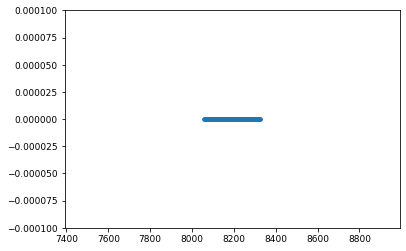

In [83]:
# print(ge)
plt.plot(ge0,'.')
dN = 800
plt.xlim([2**(L-1)-dN,2**(L-1)+dN])
plt.ylim([-1e-4,1e-4])
# print(es.shape)
# print(H1.shape)

In [55]:
r=2
dN=50
Na=10
Nb = L-Na
states=np.arange(2**(L-1)-dN,2**(L-1)+dN)

neg_q=np.zeros((int(Na/2)+1,len(Ds),len(states)))
mI_q=np.zeros((int(Na/2)+1,len(states)))
mI_q0=np.zeros((int(Na/2)+1,len(states)))

dims_a = [r] * Na
dims = [r] * L
N = prod(dims)

t_timer=time.time()
for i_D in range(len(Ds)):
    for i_s in range(len(states)):
        print(i_s)#, end='\r')
        st_num= states[i_s]
        print('D=%.2f' % (Ds[i_D]),'En=',ge[st_num,i_D])
        psi = es[:,st_num,i_D]

        for i_n in range(int(Na/2)):
            print(i_n, end='\r')
            Na1= i_n+1
            Na2= Na-i_n-1
    #         neg_q[i_n+1,i_s]=negativity_subsys_approx(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
            neg_q[i_n+1,i_D,i_s]=logneg_subsys(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))

    #         mI_q[i_n+1,i_s]=mutinf_subsys(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
    #         mI_q0[i_n+1,i_s]=mutinf_subsys(psi0, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))
#             mI_q[i_n+1,i_s]=quimb.calc.logneg(psi, dims=(2**Na1,2**(Na2+Nb)), sysa=0 ) \
#                             + quimb.calc.logneg(psi, dims=(2**Na2,2**(Na1+Nb)), sysa=0)\
#                             - quimb.calc.logneg(psi, dims=(2**Nb,2**Na), sysa=0)
#             mI_q0[i_n+1,i_s]=quimb.calc.logneg(psi0, dims=(2**Na1,2**(Na2+Nb)), sysa=0 ) \
#                             + quimb.calc.logneg(psi0, dims=(2**Na2,2**(Na1+Nb)), sysa=0)\
#                             - quimb.calc.logneg(psi0, dims=(2**Nb,2**Na), sysa=0)
        
elapsed = time.time() - t_timer
print("Finished, quimb elapsed time = %.2f " % (elapsed)+ "sec")

f1= 'XXZchain_NA_%d_NB_%d.npz' % (Na,Nb)
out_dir = 'LN_figs/' 
fname = out_dir+f1
np.savez(fname, neg_q=neg_q)



0
D=0.00 En= 0.00028348507950977055
1
D=0.00 En= 0.0002846848174591745
2
D=0.00 En= 0.0002846848174594536
3
D=0.00 En= 0.0002846848174602405
4
D=0.00 En= 0.0002846848174605706
5
D=0.00 En= 0.00028543741037140785
6
D=0.00 En= 0.00028543741037165667
7
D=0.00 En= 0.0002854374103725292
8
D=0.00 En= 0.0002854374103728951
9
D=0.00 En= 0.0002856967235181325
10
D=0.00 En= 0.0002856967235185675
11
D=0.00 En= 0.00028569672351898566
12
D=0.00 En= 0.0002856967235199317
13
D=0.00 En= 0.0002857001050635993
14
D=0.00 En= 0.0002857001050640887
15
D=0.00 En= 0.0002857001050640952
16
D=0.00 En= 0.000285700105064353
17
D=0.00 En= 0.0002857003887744123
18
D=0.00 En= 0.0002857003887745112
19
D=0.00 En= 0.0002857003887745893
20
D=0.00 En= 0.0002857003887753351
21
D=0.00 En= 0.0002857078388957367
22
D=0.00 En= 0.0002857078388964865
23
D=0.00 En= 0.0002857078388966183
24
D=0.00 En= 0.00028570783889692996
25
D=0.00 En= 0.00028570853471827993
26
D=0.00 En= 0.0002857085347187013
27
D=0.00 En= 0.00028570853471952

35
D=0.20 En= 0.08884677956222199
36
D=0.20 En= 0.08884677956222273
37
D=0.20 En= 0.08961879431778415
38
D=0.20 En= 0.08961879431778551
39
D=0.20 En= 0.08961879431778558
40
D=0.20 En= 0.08961879431778737
41
D=0.20 En= 0.1047842520898205
42
D=0.20 En= 0.10478425208982053
43
D=0.20 En= 0.10478425208982091
44
D=0.20 En= 0.10478425208982098
45
D=0.20 En= 0.10645063136567691
46
D=0.20 En= 0.10645063136567744
47
D=0.20 En= 0.1064506313656783
48
D=0.20 En= 0.10645063136567941
49
D=0.20 En= 0.10729469724397754
50
D=0.20 En= 0.10729469724397818
51
D=0.20 En= 0.10862796361939892
52
D=0.20 En= 0.10862796361939958
53
D=0.20 En= 0.10862796361939969
54
D=0.20 En= 0.10862796361940144
55
D=0.20 En= 0.11061843406474371
56
D=0.20 En= 0.11061843406474378
57
D=0.20 En= 0.11061843406474423
58
D=0.20 En= 0.11061843406474596
59
D=0.20 En= 0.11342540937828391
60
D=0.20 En= 0.11342540937828392
61
D=0.20 En= 0.11771940399950642
62
D=0.20 En= 0.11771940399950663
63
D=0.20 En= 0.1229813476019425
64
D=0.20 En= 0.1

79
D=0.40 En= 0.24460422642308546
80
D=0.40 En= 0.24460422642308555
81
D=0.40 En= 0.2455042400364234
82
D=0.40 En= 0.24550424003642368
83
D=0.40 En= 0.2508344412422867
84
D=0.40 En= 0.2508344412422873
85
D=0.40 En= 0.25083444124228765
86
D=0.40 En= 0.2508344412422881
87
D=0.40 En= 0.25305721201392867
88
D=0.40 En= 0.25305721201393033
89
D=0.40 En= 0.25556179422805236
90
D=0.40 En= 0.25556179422805264
91
D=0.40 En= 0.2555617942280535
92
D=0.40 En= 0.2555617942280538
93
D=0.40 En= 0.26163342965723446
94
D=0.40 En= 0.26163342965723524
95
D=0.40 En= 0.2837536101975244
96
D=0.40 En= 0.28375361019752465
97
D=0.40 En= 0.28917142214512004
98
D=0.40 En= 0.28917142214512137
99
D=0.40 En= 0.28917142214512137
0
D=0.50 En= 0.24011032573427823
1
D=0.50 En= 0.24011032573427832
2
D=0.50 En= 0.24011032573427832
3
D=0.50 En= 0.24011032573427865
4
D=0.50 En= 0.24011032573427948
5
D=0.50 En= 0.24649408377511728
6
D=0.50 En= 0.24649408377511864
7
D=0.50 En= 0.24649408377511878
8
D=0.50 En= 0.24649408377511

25
D=0.70 En= 0.3063064349608426
26
D=0.70 En= 0.30630643496084264
27
D=0.70 En= 0.3063064349608429
28
D=0.70 En= 0.31040666057323624
29
D=0.70 En= 0.3104066605732378
30
D=0.70 En= 0.31040666057323835
31
D=0.70 En= 0.31040666057324046
32
D=0.70 En= 0.31394139481552885
33
D=0.70 En= 0.3139413948155298
34
D=0.70 En= 0.31394139481553
35
D=0.70 En= 0.3139413948155302
36
D=0.70 En= 0.3311364350181321
37
D=0.70 En= 0.331136435018134
38
D=0.70 En= 0.33366808127802894
39
D=0.70 En= 0.3336680812780303
40
D=0.70 En= 0.33366808127803094
41
D=0.70 En= 0.3336680812780331
42
D=0.70 En= 0.33711537032123645
43
D=0.70 En= 0.3371153703212368
44
D=0.70 En= 0.3378760875591154
45
D=0.70 En= 0.33787608755911547
46
D=0.70 En= 0.3382288721055846
47
D=0.70 En= 0.3382288721055867
48
D=0.70 En= 0.3385271723021254
49
D=0.70 En= 0.3385271723021261
50
D=0.70 En= 0.33852717230212703
51
D=0.70 En= 0.3385271723021282
52
D=0.70 En= 0.33927592716968874
53
D=0.70 En= 0.3392759271696892
54
D=0.70 En= 0.3392759271696895
55

72
D=0.90 En= 0.35746274576401454
73
D=0.90 En= 0.3574627457640152
74
D=0.90 En= 0.36362606585453905
75
D=0.90 En= 0.36362606585453944
76
D=0.90 En= 0.3707264423326888
77
D=0.90 En= 0.3707264423326889
78
D=0.90 En= 0.3707264423326893
79
D=0.90 En= 0.37072644233268937
80
D=0.90 En= 0.3753333024504734
81
D=0.90 En= 0.3753333024504736
82
D=0.90 En= 0.3772094698232617
83
D=0.90 En= 0.37720946982326287
84
D=0.90 En= 0.3772094698232629
85
D=0.90 En= 0.37720946982326375
86
D=0.90 En= 0.37830991954053705
87
D=0.90 En= 0.37830991954053733
88
D=0.90 En= 0.378309919540538
89
D=0.90 En= 0.37830991954053816
90
D=0.90 En= 0.38173129603219375
91
D=0.90 En= 0.3817312960321952
92
D=0.90 En= 0.3817312960321956
93
D=0.90 En= 0.3817312960321964
94
D=0.90 En= 0.38182570795295334
95
D=0.90 En= 0.38182570795295423
96
D=0.90 En= 0.38182570795295445
97
D=0.90 En= 0.3818257079529566
98
D=0.90 En= 0.38785273696461886
99
D=0.90 En= 0.3878527369646191
0
D=1.00 En= 0.2711056984283287
1
D=1.00 En= 0.2711056984283292

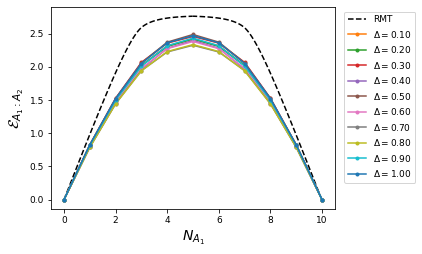

In [61]:
# L = 14
# Na=8
# Nb = L-Na

R12_list=np.linspace(0.0,0.499,101)
logneg=np.zeros(len(R12_list))
for i_1 in range(len(R12_list)-1):
    R12=R12_list[i_1+1]
    Lb= r**Nb
    L1= r**(R12*Na)
    L2= r**((1-R12)*Na)

    a = Lb/L2 +1j*0
    b = Lb/L2*L1 +1j*0
    logneg[i_1+1]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))


# f1= 'LN_figs/spinchain_NA_%d_NB_%d.npz' % (Na,Nb)
# if path.exists(fname):
#     npzfile = np.load(fname)
#     neg_q=npzfile['neg_q']
#     neg_q0=npzfile['neg_q0']
#     print('Averaged over %d states' % (np.size(neg_q,1)))


plt.figure(figsize=(6.2,3.6))
fsize=9
plt.rcParams.update({'font.size': fsize})

plt.plot(R12_list*Na,logneg,'k--')
plt.plot((0.5+R12_list[::-1])*Na,logneg,'k--',label='RMT')

# logneg_q_avg=np.log2(2*np.mean(neg_q,axis=1)+1)
logneg_q_avg= np.mean(neg_q,axis=2)
# mI_q_avg= np.mean(mI_q,axis=1)/2
# mI_q0_avg= np.mean(mI_q0,axis=1)/2

mksize=6
midsize=int(Na/2)

for i_D in np.arange(1,len(Ds)):
    yy = np.concatenate((logneg_q_avg[0:midsize,i_D],logneg_q_avg[::-1,i_D]))
    plt.plot(np.arange(0,Na+1), yy, '.-', color='C%d' % (i_D), markersize=mksize,label=r'$\Delta= %.2f$' % (Ds[i_D]))
#     plt.plot(np.arange(0,Na/2), logneg_q_avg[0:midsize,i_D], '.-', color='C%d' % (i_D), markersize=mksize,label=r'$\Delta= %.2f$' % (Ds[i_D]))
#     plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q_avg[::-1,i_D], '.-', color='C%d' % (i_D), markersize=mksize)

# plt.title('$N_A$=%d' % (Na))
plt.xlabel(r'$N_{A_1}$',fontsize = fsize+5)
plt.ylabel(r'${\cal E}_{A_1:A_2}$',fontsize = fsize+6)

# plt.ylim(0,5.)
# plt.xlim(0,int(Lab)/2+1)
# plt.legend(fontsize=fsize,handlelength=1.5,loc='lower center')
plt.legend(fontsize=fsize,bbox_to_anchor=(1.3, 1.), loc="upper right", ncol=1)

plt.tight_layout()
plt.savefig('figs/XXZ_chain2_Na_%d_Nb_%d.pdf' % (Na,Nb))
plt.show()

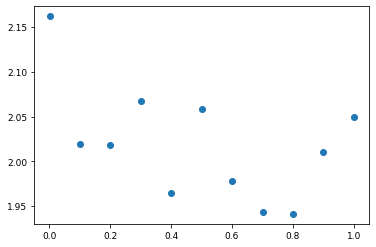

In [58]:
plt.plot(Ds,logneg_q_avg[3,:],'o');